In [23]:
from rdkit import Chem
from tqdm import tqdm    

with open("oc8b00718_si_002.txt", "r") as f:
    lines = f.readlines()[28:]

smiles = []
mols = []
perms = []
for l in tqdm(lines):
    l = l.rstrip().split()
    smi = l[0]
    try:
        perm = float(l[-1])
    except:
        continue
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    smiles += [smi]
    mols += [mol]
    perms += [perm]

100%|██████████| 92456/92456 [00:05<00:00, 17187.45it/s]


In [27]:
import numpy as np

y = np.array(perms)
X = np.zeros((len(y), NBITS), dtype=np.int8)

In [30]:
from rdkit.Chem import rdMolDescriptors as rd

RADIUS = 3
NBITS = 2048
DTYPE = np.int8


def clip_sparse(vect, nbits):
    l = [0]*nbits
    for i,v in vect.GetNonzeroElements().items():
        l[i] = v if v < 127 else 127
    return l


class Descriptor(object):

    def __init__(self):
        self.nbits = NBITS
        self.radius = RADIUS

    def calc(self, mol):
        v = rd.GetHashedMorganFingerprint(mol, radius=self.radius, nBits=self.nbits)
        return clip_sparse(v, self.nbits)

desc = Descriptor()
for i, mol in tqdm(enumerate(mols)):
    X[i,:] = desc.calc(mol)

91372it [00:30, 3038.55it/s]


In [33]:
from flaml import AutoML

In [35]:
mdl = AutoML()

time_budget = 60

automl_settings = {
    "time_budget": int(time_budget) * 60,  #  in seconds
    "metric": "auto",
    "task": "regression",
    "log_file_name": "automl.log",
    "verbose": 1,
}

mdl.fit(X, y, **automl_settings)

[flaml.automl: 11-10 12:48:48] {1432} INFO - Evaluation method: holdout
[flaml.automl: 11-10 12:48:48] {1478} INFO - Minimizing error metric: 1-r2
[flaml.automl: 11-10 12:48:48] {1515} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 11-10 12:48:48] {1748} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-10 12:54:53] {1866} INFO - Estimated sufficient time budget=30037415s. Estimated necessary time budget=64580s.
[flaml.automl: 11-10 12:54:53] {1944} INFO -  at 365.5s,	estimator lgbm's best error=0.8400,	best estimator lgbm's best error=0.8400
[flaml.automl: 11-10 12:54:53] {1748} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-10 12:57:55] {1944} INFO -  at 546.9s,	estimator lgbm's best error=0.8400,	best estimator lgbm's best error=0.8400
[flaml.automl: 11-10 12:57:55] {1748} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-10 13:03:32] {1944} INFO -  at 884.4s,	estimator lgbm's best error=0.69

[flaml.automl: 11-10 13:38:37] {1944} INFO -  at 2989.0s,	estimator extra_tree's best error=0.2766,	best estimator xgboost's best error=0.2311
[flaml.automl: 11-10 13:38:37] {1748} INFO - iteration 36, current learner extra_tree
[flaml.automl: 11-10 13:38:50] {1944} INFO -  at 3001.8s,	estimator extra_tree's best error=0.2766,	best estimator xgboost's best error=0.2311
[flaml.automl: 11-10 13:38:50] {1748} INFO - iteration 37, current learner extra_tree
[flaml.automl: 11-10 13:39:05] {1944} INFO -  at 3017.0s,	estimator extra_tree's best error=0.2766,	best estimator xgboost's best error=0.2311
[flaml.automl: 11-10 13:39:05] {1748} INFO - iteration 38, current learner xgboost
[flaml.automl: 11-10 13:48:30] {1944} INFO -  at 3582.2s,	estimator xgboost's best error=0.1840,	best estimator xgboost's best error=0.1840
[flaml.automl: 11-10 13:48:30] {1748} INFO - iteration 39, current learner rf
[flaml.automl: 11-10 13:48:32] {1944} INFO -  at 3584.2s,	estimator rf's best error=0.7214,	best e

In [36]:
joblib.dump(mdl, "../checkpoints/flaml.joblib")

['../checkpoints/flaml.joblib']

In [40]:
ypred = mdl.predict(X[:100])

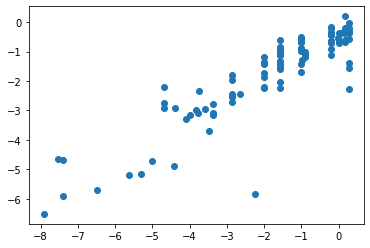

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(y[:100], ypred)